This notebook consists of

(i) finetunes TimeSformer that was pretrained on k400 dataset. trained from scratch k classifier layer (k=3 currently)

(ii) reference: https://huggingface.co/docs/transformers/main/tasks/video_classification

In [ ]:
#@title Codes to mount your google drive folder
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab_Notebooks/SMU_MITB_NLP/group_project/notebooks/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/SMU_MITB_NLP/group_project/notebooks


In [ ]:
#@title Pip install requirements.txt
!pip install -r requirements.txt

Why TimeSformer?

https://ai.meta.com/blog/timesformer-a-new-architecture-for-video-understanding/

In [ ]:
#@title Add Cuda Device
import torch
device = 0 if torch.cuda.is_available() else -1  # device 0 for the first GPU
device

0

In [ ]:
#@title Import necessary libraries
import os
import logging
from pathlib import Path
from dotenv import load_dotenv
import pandas as pd

import openai
import logging

import cv2
import base64

from tqdm import tqdm
#from video_processor import extract_encode_frames, create_message
#from openai_client import get_commentary_for_frames
from transformers import AutoImageProcessor, TimesformerForVideoClassification
import av
import torch
import numpy as np

import glob
import urllib.request

import torch.nn as nn
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from datetime import datetime
import torch.nn.functional as F
from torch.utils.data import random_split


In [ ]:
#@title old df, to use Leo's instead?
df = pd.read_csv(r'./data/raw/NSVA_Data/NSVA_Data/0021800013-dal-vs-phx-exploded.csv')
print(df.columns)
#df[['description','delexicalized_description']].head()
print(df.shape)
df.head(2)

Index(['Unnamed: 0', 'actionNumber', 'actionType', 'clock', 'description',
       'isFieldGoal', 'location', 'period', 'personId', 'playerName',
       'playerNameI', 'pointsTotal', 'scoreAway', 'scoreHome', 'shotDistance',
       'shotResult', 'subType', 'teamId', 'teamTricode', 'videoAvailable',
       'xLegacy', 'yLegacy', 'video_url', 'video_id', 'data_split_id',
       'delexicalized_description', 'players_in_description',
       'action_type_code'],
      dtype='object')
(223, 28)


,Unnamed: 0,actionNumber,actionType,clock,description,isFieldGoal,location,period,personId,playerName,...,teamTricode,videoAvailable,xLegacy,yLegacy,video_url,video_id,data_split_id,delexicalized_description,players_in_description,action_type_code
0,0,4.0,Jump Ball,PT12M00.00S,Jump Ball Ayton vs. Jordan: Tip to Smith Jr.,0.0,h,1.0,1629028.0,Ayton,...,PHX,1.0,0.0,0.0,https://videos.nba.com/nba/pbp/media/2018/10/1...,10977,train-10977,Jump Ball PLAYER1629028 vs. PLAYER201599: Tip ...,PLAYER1629028 PLAYER201599 PLAYER1628372,action41
1,1,7.0,Missed Shot,PT11M43.00S,MISS Matthews 3PT Jump Shot,1.0,v,1.0,202083.0,Matthews,...,DAL,1.0,-230.0,-2.0,https://videos.nba.com/nba/pbp/media/2018/10/1...,10978,train-10978,MISS PLAYER202083 3PT Jump Shot,PLAYER202083,action109


In [ ]:
def read_video_pyav(container, indices):
    '''
    Decode the video with PyAV decoder.
    Args:
        container (`av.container.input.InputContainer`): PyAV container.
        indices (`List[int]`): List of frame indices to decode.
    Returns:
        result (np.ndarray): np array of decoded frames of shape (num_frames, height, width, 3).
    '''
    frames = []
    container.seek(0)
    start_index = indices[0]
    end_index = indices[-1]
    for i, frame in enumerate(container.decode(video=0)):
        if i > end_index:
            break
        if i >= start_index and i in indices:
            frames.append(frame)
    return np.stack([x.to_ndarray(format="rgb24") for x in frames])

def sample_frame_indices(clip_len, frame_sample_rate, seg_len):
    '''
    Sample a given number of frame indices from the video.
    Args:
        clip_len (`int`): Total number of frames to sample.
        frame_sample_rate (`int`): Sample every n-th frame.
        seg_len (`int`): Maximum allowed index of sample's last frame.
    Returns:
        indices (`List[int]`): List of sampled frame indices
    '''
    converted_len = int(clip_len * frame_sample_rate)
    end_idx = np.random.randint(converted_len, seg_len)
    start_idx = end_idx - converted_len
    indices = np.linspace(start_idx, end_idx, num=clip_len)
    indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
    return indices

In [ ]:
video_paths = glob.glob('./data/raw/NSVA_Data/NSVA_Video6/*.mp4')
print('Number of videos is:',len(video_paths))
video_paths[:5]

Number of videos is: 223


['./data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10977.mp4',
 './data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10978.mp4',
 './data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10980.mp4',
 './data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10982.mp4',
 './data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10983.mp4']

In [ ]:
#@title Inference a video clip without any training.. noticed that it will inference as 'Playing Basketball'
# Example video file path
video_path = video_paths[1]

# Open the video file
container = av.open(video_path)

# Sample 8 frames from the video
indices = sample_frame_indices(clip_len=8, frame_sample_rate=1, seg_len=container.streams.video[0].frames)
video = read_video_pyav(container, indices)

In [ ]:
# Load the pretrained model and processor
image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400")
# Move the model to GPU if available
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense

In [ ]:
# Preprocess the video frames and move the inputs to the GPU
inputs = image_processor(list(video), return_tensors="pt").to(device)

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get the predicted class
predicted_label = logits.argmax(-1).item()
print(f'Predicted label: {model.config.id2label[predicted_label]}')

/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)


Predicted label: playing basketball


[link text](https://)No matter what the timesformer classifier will classify as playing basketball!

Being trained on the Kinetics-400 dataset, which includes a variety of actions, but `might not have the granularity required for specific basketball action type`.

In [ ]:
#@title lets first inspect what are the unique actions available in the dataset. As you can see, too messy with duplicates, getting Leo to work on the data engienering for handling that cases. For now ill work on simpler case to deal with single video clip first

list(df['actionType'].unique())

['Jump Ball',
 'Missed Shot',
 'Made Shot',
 'Foul',
 'Turnover',
 'Defensive Rebound',
 'period',
 'Offensive Rebound']

In [ ]:
#uncomment if not using Leo's data
'''
extracted_action_types = [actionType.split('</>')[0].strip() if "</>" in actionType else actionType.strip() for actionType in df['actionType'].unique()]
unique_actions = list(set(extracted_action_types))
print('there are {} unique actions'.format(len(unique_actions)))
print(unique_actions)
'''

there are 8 unique actions
['Jump Ball', 'Turnover', 'Made Shot', 'Missed Shot', 'period', 'Offensive Rebound', 'Foul', 'Defensive Rebound']


In [ ]:
#@title Starting from here work on the Action recognition model

In [ ]:
'''
# Load the dataset
#df = pd.read_csv('./data/raw/NSVA_Data/NSVA_Data/0021800013-dal-vs-phx.csv')
df = pd.read_csv("./data/raw/NSVA_Data/NSVA_Data/0021801227-dal-vs-sas.csv")
# Filter out rows with duplicate video URLs denoted by '</>'
filtered_df = df[~df['video_url'].str.contains('</>')]

# Save the filtered dataset to a new CSV file
filtered_df.to_csv('filtered_dataset.csv', index=False)

#check the number of unique actionType
print(filtered_df['actionType'].nunique(), 'unique actions in this df')

#see what are examples of unique actionType
print(filtered_df['actionType'].unique())

# Print the first few rows of the filtered dataset to verify
filtered_df.head()

#check number of count for unique actionType
print(filtered_df['actionType'].value_counts())
'''

8 unique actions in this df
['Jump Ball' 'Made Shot' 'Offensive Rebound' 'Missed Shot' 'Turnover'
 'Foul' 'Defensive Rebound' 'period']
actionType
Made Shot            69
Foul                 26
Missed Shot          23
Turnover             13
Defensive Rebound     9
Offensive Rebound     5
period                2
Jump Ball             1
Name: count, dtype: int64


In [ ]:
#@title Filter the dataset to ultimately 5 action types M'Turnover', 'Made Shot', 'Missed Shot', Foul', 'Rebound'

# Define the action types to include
selected_actions = ['Turnover', 'Made Shot', 'Missed Shot','Foul','Offensive Rebound', 'Defensive Rebound']

# Filter the DataFrame
filtered_df = df[df['actionType'].isin(selected_actions)]

# Instead of Defensive Reound or Offensive Rebound, change to just Rebound
filtered_df['actionType'] = filtered_df['actionType'].replace(['Defensive Rebound', 'Offensive Rebound'], 'Rebound')

# print sum of all actionTypes
print(sum(filtered_df['actionType'].value_counts()))

# Verify the filtered dataset
print(filtered_df['actionType'].value_counts())

# Map selected actions to numeric labels
label_to_idx = {label: idx for idx, label in enumerate(['Turnover', 'Made Shot', 'Missed Shot','Foul','Rebound'])}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}



# Update the dataset with numeric labels
filtered_df['label'] = filtered_df['actionType'].map(label_to_idx) # i think label and actionTypecode is the same

# Verify the filtered dataset
print(filtered_df['label'].value_counts())

# Save the updated dataset
filtered_df.to_csv('final_filtered_dataset.csv', index=False)

220
actionType
Missed Shot    82
Made Shot      81
Foul           33
Turnover       17
Rebound         7
Name: count, dtype: int64
label
2    82
1    81
3    33
0    17
4     7
Name: count, dtype: int64


<ipython-input-15-de63942f1399>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['actionType'] = filtered_df['actionType'].replace(['Defensive Rebound', 'Offensive Rebound'], 'Rebound')
<ipython-input-15-de63942f1399>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['label'] = filtered_df['actionType'].map(label_to_idx) # i think label and actionTypecode is the same


In [ ]:
#@title /notebooks/filetered_dataset.csv is my master file
filtered_df.head(2)

,Unnamed: 0,actionNumber,actionType,clock,description,isFieldGoal,location,period,personId,playerName,...,videoAvailable,xLegacy,yLegacy,video_url,video_id,data_split_id,delexicalized_description,players_in_description,action_type_code,label
1,1,7.0,Missed Shot,PT11M43.00S,MISS Matthews 3PT Jump Shot,1.0,v,1.0,202083.0,Matthews,...,1.0,-230.0,-2.0,https://videos.nba.com/nba/pbp/media/2018/10/1...,10978,train-10978,MISS PLAYER202083 3PT Jump Shot,PLAYER202083,action109,2
2,2,9.0,Missed Shot,PT11M26.00S,MISS Booker 25' 3PT Pullup Jump Shot,1.0,h,1.0,1626164.0,Booker,...,1.0,-20.0,253.0,https://videos.nba.com/nba/pbp/media/2018/10/1...,10980,train-10980,MISS PLAYER1626164 25' 3PT Pullup Jump Shot,PLAYER1626164,action111,2


In [ ]:
#@title Downloading process of all the games from filtered_df.. need to change accordingly if needed others

'''
# Iterate over the filtered DataFrame
for index, row in tqdm(filtered_df.iterrows(), total=len(filtered_df), desc="Downloading videos"):
    game_name = row['video_id']
    video_url = row['video_url']
    print(video_url)
    # Create a unique filename for each video
    file_name = f"./data/raw/NSVA_Data/NSVA_Video5/0021801227-dal-vs-sas_{game_name}.mp4"
    print(f"Downloading {file_name}")

    # Download the video
    urllib.request.urlretrieve(video_url.strip(), file_name)

print("All videos downloaded successfully.")
'''


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/7/1c2e7a23-d47f-17b9-79ff-fac01f9b9f96_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/10/ca0bc14a-7d86-fa7b-e511-934ca3de80f4_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/11/e06594e3-14d7-ff78-418c-4eda5c8bb086_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/18/85d8f9a6-1d34-0cb9-cf29-214107717c02_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/22/b77a986c-d8d2-f2c5-1116-575d6c37d34b_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/25/1b136870-f899-641a-e7f7-f23b5cac6fc9_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/29/09bab586-cc5f-cef7-9dcc-88eeffd51fb6_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/33/b8519155-5cfc-3d0e-ec1f-6e47e006f2a0_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/35/c17f0cb7-0218-01e8-8eb6-736f324ad991_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/37/e2cf5c9a-bc05-bb67-7cfc-5b05ac7eb08a_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/39/bf878af6-d7ee-f1af-80c9-7b9ea819c16e_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/41/8007dd33-5fa1-a808-b324-7faa0b3d57e1_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/48/91eed724-3d7d-bf27-24e2-436ad334c0cb_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/52/fabe6a90-b09a-434f-614d-088dd853b3d1_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/56/d21b8bd2-b091-97ed-08b5-23d3ff526180_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/67/034a808e-7392-2226-47e5-d0336f5c8fb7_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/70/c0e86627-775b-2ced-fca0-f8577b42cc7a_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/73/bea1e10b-123e-2d7c-aa45-3fcf1d0414d0_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/75/0d948527-094e-3817-29c2-65d079839dc8_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/77/48be8559-101b-61d9-1ed8-29bcccf2180a_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/94/91d36324-40ac-7970-4688-7c07ce44d80e_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/97/0c27582d-d164-9f2f-3b7b-2658b4d11a0d_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/98/31e5f790-a738-01f3-5f81-8498697618e2_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/101/4b6d1a25-3b5b-ed87-16eb-0c124fe24db9_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/108/9019ce31-a86b-8445-7085-d031f882247d_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/115/20f4f03e-1924-f900-129a-27bace40f4ed_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/122/6d3dd442-9287-fa33-8f1c-7f7c5368b8a5_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/128/82e9915f-59e9-989e-906d-aac0a666b29f_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/130/42adbc83-ef44-34b4-80c6-b1e516834bd5_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/132/1f7e6676-e81d-d096-7399-a9de386b6a37_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/145/28f4cad4-4ef8-4ba3-67af-8962d0c2528b_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/146/549ca302-1d98-7c97-e2ce-8c661a966829_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/156/56ef497c-2910-a322-cec0-d6c15043de13_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/165/10ad9c05-d777-5b1c-b953-c9c9099b84ad_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/173/12bfab26-3219-3e35-8eb7-57ace1945c3c_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/174/67377f80-9016-ed4c-18f3-2f78bee50131_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/182/6fd05316-16f2-7c6e-33d5-80665e7755cb_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/186/98370247-0935-4575-3963-24e8f991a259_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/192/47c12dc1-0389-52ca-ae87-ae855059fd69_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/198/366601ff-f1d7-1b71-7b4b-84df5b86c5f0_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/201/d46e6cf4-f0af-c9d1-03e5-7e7b936b45a2_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/204/2e51b9d3-12f5-62f8-7446-07b38093364a_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/206/b9dc5a44-773a-dcb6-cb4f-3de4a7ae864a_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/214/6d1132cd-f830-8cca-5688-ae574ee10f50_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/236/118c1d8a-c66b-216e-a05c-e7ee4bae0ac5_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/237/cb05c2df-6497-9596-0d0c-2eaf14adb260_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/239/7f034eee-f733-35cf-ecac-dc0a3b43a38c_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/247/19f1f515-d53f-2bc6-d90f-450ad2b7fde7_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/251/955d4d6f-e8ab-173b-505f-c7c1e7e7154f_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/252/40e76744-0780-de1b-39bf-2c43386291b6_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/261/76072cdc-26d5-8827-26ac-d3b5e86314e0_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/262/bf26a461-24cd-0de9-ea35-03667e22874e_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/264/a8beb716-fe0b-a114-a3f3-0178e633964f_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/266/3c6fece7-04c3-7c15-6f3b-7ec45021957b_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/272/51ef7db7-dca9-b5be-c984-7b18a822416f_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/282/487abc0d-1ae1-e046-665c-6001cfc595c0_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/290/f7844bbf-45dd-06c2-2007-255a5e54017e_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/296/d42b9e95-0f99-9847-60a8-1e631f1b31cc_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/297/1d33c121-cb0f-08b7-494a-3e1edfec182e_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/299/2ee44009-1425-db22-0c47-9b2f37e45c22_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/306/3d698a32-b385-326e-ce38-e8f8adc76495_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/309/02cce4eb-35bc-8a3b-64d1-5a8de9b3d855_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/311/da81b6fa-cad4-a415-93ef-23d7745f2f00_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/317/f6b68988-51ab-69ba-c111-a3e6a80a74e0_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/322/615f6e0b-ee5b-f100-133c-537569f78ada_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/337/cfcba444-f34c-8ab9-417b-8fab30e59097_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/339/11b7e2be-fe8a-77d2-0d5e-fc9323034a11_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/341/4775ff3f-2554-ca64-97d8-6f8e309272e2_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/347/07a34b14-d495-99ac-4e6a-a4a4865e5ae5_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/351/7ba7aeb8-d2a0-187e-27b3-7b3b19f2540d_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/357/8aa458d6-c56b-5856-399e-db44e5da0275_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/358/7004f7c1-db94-76b3-7876-793a937f360b_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/360/629f57de-bcd7-3561-e442-8e1b71796ce9_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/362/adb3596b-6f50-fc31-1acd-6b49ca5838c8_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/364/4e60a352-3efb-b434-fede-78df0fddaa96_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/370/0bee9735-136d-91ad-5557-452b153053a7_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/372/5f2cea9a-ea0b-1a92-8038-9a9ed069333d_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/375/7ff45a7c-ba95-a218-a850-2c01e4862b08_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/376/dfe4fac9-bffc-96e7-281e-4a1c1daa6128_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/377/066e6068-93a3-8bbc-0cc0-06a5fe51e1b3_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/379/be4f4c44-118f-30a2-1b8a-0c4b5293d3a4_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/381/fbbcb92d-8dba-6a25-b43e-843fb15eaf5f_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/385/204d8356-c66f-f976-25b9-59ac9f2c1a75_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/388/e2f2ce27-e3c6-6904-eed4-b9653db774d4_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/396/0648db12-0dda-b36d-627b-c8ed1190ba3c_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/404/a88e91fc-861b-ac83-0d90-5aad1243f0bc_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/408/dc945f98-3cb9-e750-bee9-b776ef08ae05_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/409/27ff3ed6-25f7-50df-42c7-65c94b26f360_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/416/a6a9a510-0f50-dc11-16d1-47f4f9946778_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/417/97ae11ca-f314-6c7e-cdbe-cbec51c837e4_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/420/4476155a-d0e8-e77b-1be3-e31347a96fd5_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/425/4a579371-b078-98da-eeb2-d39d7fac94b6_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/426/0d1009d2-dccd-2b81-6bc4-fcedee392e20_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/436/f2ff7a49-a76c-120c-8d3f-57f75d22b726_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/442/2a9db7c0-1bbc-2595-a334-21ada00d49fa_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/447/65cf6e06-66d1-b0c3-b8cd-df537771bee5_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/448/d9ba31f1-e825-f070-bed5-9b09cfce1efe_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/451/810a70b0-614e-fe73-112e-8d25e77d51cc_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/453/d87dd8bd-c1c7-09f3-b644-9a0ad2ad618a_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/455/07d31226-f5fd-71e7-6749-9462838b4dde_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/458/f759d631-70df-cec2-18ca-a85a1adc728f_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/460/988eb741-b2ff-433e-13b8-6350ccfbdef7_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/464/1eeb432e-dd2f-60d1-38d3-6a859d8b2e8b_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/476/bc84560e-8aa0-1aa8-ce8a-717d857d4937_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/485/aca09981-2eb6-60b3-74e0-a14d9d6e9fd3_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/487/e5857f2e-acf4-68f2-23b5-91892511072d_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/490/629067a9-a4e3-f261-6914-990e6b859a57_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/495/2b8a0be4-83cd-5dfc-01da-1f6f491ca28d_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/499/f94d6481-d4b1-9344-5caa-1a44e03e1295_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/506/3575c80f-7afa-3e1d-7eb8-db2cd0460dc1_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/508/46cf42b4-e6cf-890d-5cc5-a47ffaf7f4c5_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/510/810f75c0-ce6d-e0d6-8172-d2955ac50b8a_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/514/af133eb2-84a0-bd68-8806-4dcdaa8a6d71_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/518/500f0aad-29ec-07ee-9820-9d930f4ed770_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/537/1023ebf3-0536-84b1-8fb1-fa43e779f690_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/539/aaa28aea-482d-a0b9-7b11-5a0dc16ff270_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/547/8a1f4f13-f266-3dd5-f832-02ecbbff2234_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/550/a6256400-69e1-433f-56fb-2746ae3bf2d3_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/553/c82f0d9a-45fd-3531-5172-8d7d6e7fba8c_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/556/402925b2-3d6b-920e-92a8-4332f0febc99_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/560/cb560c5f-863b-0792-b63d-c0eda53669f9_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/567/f8b057bf-7e76-e4f0-47f3-22e9707ecb5d_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/573/46a1736c-b67c-d06b-e730-9f4437e721c0_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/577/ebf9ffca-a5db-1ef7-8b98-a8869059850c_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/579/915ce43c-e679-a92f-09ef-9ceadcc28a39_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/602/0784feec-884b-0159-0463-6384ba103a43_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/605/b94f9fe9-e5a0-eae1-2dcc-a9b1286cff2e_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/607/892e39be-981b-eade-29ac-b2281ac86531_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/616/82b5d750-ca99-1669-0e6f-ea59724406b9_1280x720.mp4


https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/617/a9c48ca1-2e1d-3db3-96fb-7abc492b1561_1280x720.mp4
https://videos.nba.com/nba/pbp/media/2019/04/10/0021801227/623/ef9ea596-7113-028b-f9e7-325b528ad814_1280x720.mp4


All videos downloaded successfully.


In [ ]:
import pandas as pd
from pathlib import Path
import av
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt


class BasketballDataset(Dataset):
    def __init__(self, csv_file, root_dir, clip_len=12, frame_sample_rate=1, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = Path(root_dir)
        self.clip_len = clip_len
        self.frame_sample_rate = frame_sample_rate
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Read the video file path and label
        video_id = self.annotations.iloc[idx]['video_id']
        label = self.annotations.iloc[idx]['label']
        action_type = self.annotations.iloc[idx]['actionType']

        video_path = self.root_dir / f"0021800013-dal-vs-phx_{video_id}.mp4"
        #video_path = self.root_dir / f"0021800013-dal-vs-phx_{video_id}.mp4"

        # Read video
        container = av.open(str(video_path))
        indices = self.sample_frame_indices(container.streams.video[0].frames)
        video = self.read_video_pyav(container, indices)

        if self.transform:
            video = self.transform(video)

        return video, label, action_type, str(video_path)

    def sample_frame_indices(self, num_frames):
        # Ensure unique frame indices are sampled
        total_frames = num_frames
        frame_indices = np.linspace(0, total_frames - 1, self.clip_len, dtype=np.int64)
        return frame_indices

    def read_video_pyav(self, container, indices):
        frames = []
        container.seek(0)
        for i, frame in enumerate(container.decode(video=0)):
            if i in indices:
                frames.append(frame)
            if len(frames) == len(indices):
                break
        return np.stack([x.to_ndarray(format="rgb24") for x in frames])

# Initialize the image processor
image_processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k400")

def transform(video):
    # Transform the video frames using the image processor
    video_frames = [frame for frame in video]
    inputs = image_processor(video_frames, return_tensors="pt")
    return inputs["pixel_values"].squeeze(0)

In [ ]:
#@title Offline check process [1/2]
# Path to the directory containing the video files
root_dir = Path('./data/raw/NSVA_Data/NSVA_Video6/')

# Path to the cleaned CSV file
csv_file = 'final_filtered_dataset.csv'


# Create the dataset
dataset  = BasketballDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# Define the size of train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# Split the dataset
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create the DataLoader for training and testing
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

# Ensure CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Fetch a batch of data for offline check
data_iter = iter(train_loader)
videos, labels, action_types, video_paths = next(data_iter)

# Print the shapes of the batch
print(f'Batch of videos shape: {videos.shape}')  # Should be (batch_size, num_frames, height, width, channels)
print(f'Batch of labels shape: {labels.shape}')  # Should be (batch_size,)
print(f'Batch of action types: {action_types}')  # Action types corresponding to each video
print(f'Batch of video paths: {video_paths}')  # Paths to the videos


# Adjust the video tensor shape
videos = videos.permute(0, 2, 1, 3, 4).to(device)  # From (batch_size, num_frames, height, width, channels) to (batch_size, channels, num_frames, height, width)

# Print the adjusted shape
print(f'Adjusted batch of videos shape: {videos.shape}')  # Should be (batch_size, channels, num_frames, height, width)


Using device: cuda


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)


Batch of videos shape: torch.Size([4, 12, 3, 224, 224])
Batch of labels shape: torch.Size([4])
Batch of action types: ('Foul', 'Made Shot', 'Made Shot', 'Missed Shot')
Batch of video paths: ('data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_11193.mp4', 'data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_11010.mp4', 'data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_11276.mp4', 'data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_11012.mp4')
Adjusted batch of videos shape: torch.Size([4, 3, 12, 224, 224])


Label: 1
Action Type: Made Shot
Video Path: data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_11226.mp4


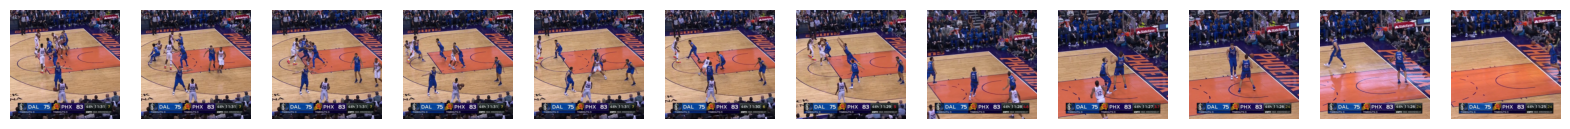

In [ ]:
#@title Offline check process [1/2]

#label index 0 is Foul,
#label index 1 is Made Shot,
#label index 2 is Turnover

# Function to visualize video frames
def visualize_video_frames(video_batch, labels_batch, action_types_batch, video_paths_batch, idx=2):
    video = video_batch[idx].cpu()  # Take the first video in the batch and move to CPU for visualization
    label = labels_batch[idx]  # Corresponding label
    action_type = action_types_batch[idx]  # Corresponding action type
    video_path = video_paths_batch[idx]  # Corresponding video path

    print(f'Label: {label}')
    print(f'Action Type: {action_type}')
    print(f'Video Path: {video_path}')

    # Normalize video frames for display
    #video = video / 255.0

    # Plot video frames
    num_frames = video.shape[1]  # Since channels is now the second dimension
    fig, axes = plt.subplots(1, num_frames, figsize=(20, 10))
    for i in range(num_frames):
        #axes[i].imshow(video[:, i, :, :].permute(1, 2, 0).numpy())  # Convert CHW to HWC
        frame = video[:, i, :, :].permute(1, 2, 0).numpy()  # Convert CHW to HWC
        #uncomment this line if i want to see normal image for display
        frame = (frame - frame.min()) / (frame.max() - frame.min())  # Normalize frame to [0, 1] for display
        axes[i].imshow(frame)
        axes[i].axis('off')
    plt.show()

# Visualize the first video in the batch, default index = 0 (first video)
visualize_video_frames(videos, labels, action_types, video_paths)

In [ ]:
filtered_df['label'].value_counts()

label
2    82
1    81
3    33
0    17
4     7
Name: count, dtype: int64

In [ ]:
#@title Load model, hyperparams before start training later
# Load the pretrained model and processor

#alr loaded at basketball class
#image_processor = AutoImageProcessor.from_pretrained("MCG-NJU/videomae-base-finetuned-kinetics")
model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400")
# Modify the classifier layer to match the number of classes in your dataset
#num_classes for action type
num_classes = len(filtered_df['label'].value_counts())
print(num_classes, 'classes added to the last classifier layer')
model.classifier = nn.Linear(in_features=768, out_features=num_classes, bias=True)

config.json:   0%|          | 0.00/22.7k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

5 classes added to the last classifier layer


In [ ]:
#@title Load the finetuned weights if applicable for further training

'''
# Load the finetuned model weights
checkpoint_path = './weights/action_recognition/model_epoch_5_20240618_040707.pth'
model.load_state_dict(torch.load(checkpoint_path, map_location=device))


'''

TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense

In [ ]:
from transformers import AdamW
# Define optimizer and loss function
# 3e-5 LR
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-5)
criterion = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
#@title Depending on how i want to control the finetuning process
# Freeze all layers except the classifier layer

'''
for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False
'''
# Move the model to GPU if available
model.to(device)

# Unfreeze the last few layers for fine-tuning based on model inspection
# Unfreeze the last 3 layers of the encoder
for name, param in model.named_parameters():
    if 'encoder.layer.9' in name or 'encoder.layer.10' in name or 'encoder.layer.11' in name or 'classifier' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# Check which layers are unfrozen
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Layer unfrozen: {name}")
    else:
        print(f"Layer frozen: {name}")

Layer frozen: timesformer.embeddings.cls_token
Layer frozen: timesformer.embeddings.position_embeddings
Layer frozen: timesformer.embeddings.time_embeddings
Layer frozen: timesformer.embeddings.patch_embeddings.projection.weight
Layer frozen: timesformer.embeddings.patch_embeddings.projection.bias
Layer frozen: timesformer.encoder.layer.0.attention.attention.qkv.weight
Layer frozen: timesformer.encoder.layer.0.attention.attention.qkv.bias
Layer frozen: timesformer.encoder.layer.0.attention.output.dense.weight
Layer frozen: timesformer.encoder.layer.0.attention.output.dense.bias
Layer frozen: timesformer.encoder.layer.0.intermediate.dense.weight
Layer frozen: timesformer.encoder.layer.0.intermediate.dense.bias
Layer frozen: timesformer.encoder.layer.0.output.dense.weight
Layer frozen: timesformer.encoder.layer.0.output.dense.bias
Layer frozen: timesformer.encoder.layer.0.layernorm_before.weight
Layer frozen: timesformer.encoder.layer.0.layernorm_before.bias
Layer frozen: timesformer.enc

In [ ]:
from tqdm import tqdm
import time

# Training loop
num_epochs = 5
train_acc_list = []
test_acc_list = []

train_loss_list = []
test_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_labels = []
    all_preds = []

    epoch_start_time = time.time()
    for videos, labels, action_types, video_paths in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch"):
        videos, labels = videos.to(device), labels.to(device)
        # Permute videos to match the required input size
        print('\nbefore input permute',videos.shape)
        #videos = videos.permute(0, 2, 1, 3, 4)
        #print('after input permute',videos.shape)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Store labels and predictions for accuracy calculation
        preds = outputs.logits.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    # Calculate training accuracy
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_acc_list.append(train_accuracy)
    train_loss_list.append(running_loss / len(train_loader))

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    all_test_labels = []
    all_test_preds = []

    with torch.no_grad():
        for videos, labels, action_types, video_paths in tqdm(test_loader, desc="Testing", unit="batch"):
            videos, labels = videos.to(device), labels.to(device)
            outputs = model(videos)
            loss = criterion(outputs.logits, labels)
            test_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(preds.cpu().numpy())

    test_accuracy = accuracy_score(all_test_labels, all_test_preds)
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss / len(test_loader))

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    #print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}, Time: {epoch_duration:.2f}s')
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy}, Test Loss: {test_loss/len(test_loader)}, Test Accuracy: {test_accuracy}, Time: {epoch_duration:.2f}s')

    # Save the model checkpoint with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    torch.save(model.state_dict(), f'./weights/action_recognition/final_model_epoch_{epoch+1}_{timestamp}.pth')

print('Finished Training')

Epoch 1/5:   0%|          | 0/44 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)



before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:   2%|▏         | 1/44 [00:28<20:19, 28.36s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:   5%|▍         | 2/44 [00:29<08:39, 12.37s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:   7%|▋         | 3/44 [00:48<10:26, 15.27s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:   9%|▉         | 4/44 [00:49<06:28,  9.70s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  11%|█▏        | 5/44 [01:09<08:48, 13.54s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  14%|█▎        | 6/44 [01:10<05:54,  9.34s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  16%|█▌        | 7/44 [01:31<08:04, 13.09s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  18%|█▊        | 8/44 [01:32<05:34,  9.30s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  20%|██        | 9/44 [01:55<07:47, 13.36s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  23%|██▎       | 10/44 [01:56<05:26,  9.59s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  25%|██▌       | 11/44 [02:16<07:07, 12.96s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  27%|██▋       | 12/44 [02:18<05:00,  9.39s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  30%|██▉       | 13/44 [02:39<06:40, 12.90s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  32%|███▏      | 14/44 [02:40<04:40,  9.37s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  34%|███▍      | 15/44 [03:01<06:10, 12.78s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  36%|███▋      | 16/44 [03:02<04:20,  9.29s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  39%|███▊      | 17/44 [03:21<05:33, 12.35s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  41%|████      | 18/44 [03:23<03:56,  9.09s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  43%|████▎     | 19/44 [03:43<05:12, 12.48s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  45%|████▌     | 20/44 [03:46<03:50,  9.62s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  48%|████▊     | 21/44 [04:05<04:44, 12.37s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  50%|█████     | 22/44 [04:09<03:36,  9.83s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  52%|█████▏    | 23/44 [04:27<04:17, 12.24s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  55%|█████▍    | 24/44 [04:31<03:15,  9.76s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  57%|█████▋    | 25/44 [04:49<03:53, 12.29s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  59%|█████▉    | 26/44 [04:53<02:57,  9.84s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  61%|██████▏   | 27/44 [05:10<03:26, 12.14s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  64%|██████▎   | 28/44 [05:14<02:32,  9.55s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  66%|██████▌   | 29/44 [05:33<03:06, 12.46s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  68%|██████▊   | 30/44 [05:37<02:17,  9.79s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  70%|███████   | 31/44 [05:54<02:36, 12.07s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  73%|███████▎  | 32/44 [05:59<01:57,  9.82s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  75%|███████▌  | 33/44 [06:18<02:20, 12.79s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  77%|███████▋  | 34/44 [06:22<01:41, 10.16s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  80%|███████▉  | 35/44 [06:41<01:55, 12.79s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  82%|████████▏ | 36/44 [06:46<01:23, 10.42s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  84%|████████▍ | 37/44 [07:04<01:27, 12.50s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  86%|████████▋ | 38/44 [07:09<01:01, 10.23s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  89%|████████▊ | 39/44 [07:27<01:03, 12.61s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  91%|█████████ | 40/44 [07:31<00:40, 10.02s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  93%|█████████▎| 41/44 [07:49<00:37, 12.45s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  95%|█████████▌| 42/44 [07:52<00:19,  9.76s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 1/5:  98%|█████████▊| 43/44 [08:11<00:12, 12.48s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Testing:   0%|          | 0/11 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a ten

Epoch 1/5, Train Loss: 1.370348639108918, Train Accuracy: 0.4034090909090909, Test Loss: 0.9782316522164778, Test Accuracy: 0.6363636363636364, Time: 620.20s


Epoch 2/5:   0%|          | 0/44 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:   2%|▏         | 1/44 [00:25<18:00, 25.12s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:   5%|▍         | 2/44 [00:26<07:47, 11.13s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:   7%|▋         | 3/44 [00:47<10:43, 15.68s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:   9%|▉         | 4/44 [00:48<06:40, 10.02s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  11%|█▏        | 5/44 [01:10<09:15, 14.24s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  14%|█▎        | 6/44 [01:11<06:13,  9.84s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  16%|█▌        | 7/44 [01:32<08:08, 13.20s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  18%|█▊        | 8/44 [01:33<05:39,  9.42s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  20%|██        | 9/44 [01:57<08:12, 14.07s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  23%|██▎       | 10/44 [01:58<05:44, 10.14s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  25%|██▌       | 11/44 [02:20<07:29, 13.63s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  27%|██▋       | 12/44 [02:21<05:16,  9.89s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  30%|██▉       | 13/44 [02:42<06:50, 13.23s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  32%|███▏      | 14/44 [02:44<04:49,  9.63s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  34%|███▍      | 15/44 [03:07<06:36, 13.66s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  36%|███▋      | 16/44 [03:08<04:38,  9.94s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  39%|███▊      | 17/44 [03:29<05:56, 13.19s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  41%|████      | 18/44 [03:30<04:10,  9.63s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  43%|████▎     | 19/44 [03:49<05:12, 12.48s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  45%|████▌     | 20/44 [03:50<03:38,  9.12s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  48%|████▊     | 21/44 [04:14<05:10, 13.49s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  50%|█████     | 22/44 [04:15<03:36,  9.83s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  52%|█████▏    | 23/44 [04:38<04:47, 13.70s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  55%|█████▍    | 24/44 [04:39<03:19,  9.98s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  57%|█████▋    | 25/44 [05:00<04:12, 13.29s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  59%|█████▉    | 26/44 [05:02<02:54,  9.69s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  61%|██████▏   | 27/44 [05:24<03:48, 13.44s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  64%|██████▎   | 28/44 [05:25<02:36,  9.81s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  66%|██████▌   | 29/44 [05:47<03:22, 13.52s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  68%|██████▊   | 30/44 [05:49<02:18,  9.86s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  70%|███████   | 31/44 [06:10<02:52, 13.27s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  73%|███████▎  | 32/44 [06:11<01:56,  9.69s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  75%|███████▌  | 33/44 [06:32<02:22, 12.92s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  77%|███████▋  | 34/44 [06:33<01:34,  9.44s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  80%|███████▉  | 35/44 [06:55<01:57, 13.10s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  82%|████████▏ | 36/44 [06:56<01:16,  9.56s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  84%|████████▍ | 37/44 [07:18<01:33, 13.35s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  86%|████████▋ | 38/44 [07:20<00:58,  9.74s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  89%|████████▊ | 39/44 [07:41<01:07, 13.40s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  91%|█████████ | 40/44 [07:43<00:39,  9.77s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  93%|█████████▎| 41/44 [08:03<00:39, 13.03s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  95%|█████████▌| 42/44 [08:05<00:19,  9.52s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 2/5:  98%|█████████▊| 43/44 [08:21<00:11, 11.61s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Testing:   0%|          | 0/11 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a ten

Epoch 2/5, Train Loss: 1.1617467416958376, Train Accuracy: 0.5340909090909091, Test Loss: 1.0263769626617432, Test Accuracy: 0.6136363636363636, Time: 628.41s


Epoch 3/5:   0%|          | 0/44 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a t


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:   2%|▏         | 1/44 [00:23<16:45, 23.39s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:   5%|▍         | 2/44 [00:25<07:33, 10.80s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:   7%|▋         | 3/44 [00:45<10:24, 15.24s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:   9%|▉         | 4/44 [00:47<06:38,  9.97s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  11%|█▏        | 5/44 [01:07<08:48, 13.56s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  14%|█▎        | 6/44 [01:10<06:10,  9.75s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  16%|█▌        | 7/44 [01:30<08:14, 13.35s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  18%|█▊        | 8/44 [01:34<06:07, 10.22s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  20%|██        | 9/44 [01:54<07:50, 13.43s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  23%|██▎       | 10/44 [01:57<05:43, 10.09s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  25%|██▌       | 11/44 [02:16<07:06, 12.93s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  27%|██▋       | 12/44 [02:18<05:00,  9.40s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  30%|██▉       | 13/44 [02:40<06:54, 13.36s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  32%|███▏      | 14/44 [02:41<04:51,  9.72s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  34%|███▍      | 15/44 [03:02<06:12, 12.84s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  36%|███▋      | 16/44 [03:03<04:22,  9.37s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  39%|███▊      | 17/44 [03:23<05:40, 12.62s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  41%|████      | 18/44 [03:24<03:59,  9.22s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  43%|████▎     | 19/44 [03:44<05:11, 12.46s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  45%|████▌     | 20/44 [03:47<03:47,  9.48s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  48%|████▊     | 21/44 [04:07<04:49, 12.58s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  50%|█████     | 22/44 [04:10<03:33,  9.69s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  52%|█████▏    | 23/44 [04:30<04:29, 12.82s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  55%|█████▍    | 24/44 [04:31<03:07,  9.37s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  57%|█████▋    | 25/44 [04:52<04:02, 12.76s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  59%|█████▉    | 26/44 [04:55<02:57,  9.83s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  61%|██████▏   | 27/44 [05:15<03:38, 12.82s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  64%|██████▎   | 28/44 [05:17<02:35,  9.71s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  66%|██████▌   | 29/44 [05:37<03:12, 12.82s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  68%|██████▊   | 30/44 [05:40<02:17,  9.83s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  70%|███████   | 31/44 [06:02<02:55, 13.50s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  73%|███████▎  | 32/44 [06:03<01:58,  9.86s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  75%|███████▌  | 33/44 [06:24<02:24, 13.17s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  77%|███████▋  | 34/44 [06:26<01:36,  9.62s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  80%|███████▉  | 35/44 [06:46<01:55, 12.88s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  82%|████████▏ | 36/44 [06:47<01:15,  9.41s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  84%|████████▍ | 37/44 [07:08<01:29, 12.84s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  86%|████████▋ | 38/44 [07:10<00:56,  9.38s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  89%|████████▊ | 39/44 [07:31<01:04, 12.93s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  91%|█████████ | 40/44 [07:32<00:37,  9.45s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  93%|█████████▎| 41/44 [07:52<00:37, 12.58s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  95%|█████████▌| 42/44 [07:53<00:18,  9.20s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 3/5:  98%|█████████▊| 43/44 [08:15<00:13, 13.05s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Testing:   0%|          | 0/11 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a ten

Epoch 3/5, Train Loss: 0.9563819197091189, Train Accuracy: 0.6079545454545454, Test Loss: 0.8708216141570698, Test Accuracy: 0.6136363636363636, Time: 621.59s


Epoch 4/5:   0%|          | 0/44 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a t


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:   2%|▏         | 1/44 [00:23<17:09, 23.95s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:   5%|▍         | 2/44 [00:25<07:26, 10.64s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:   7%|▋         | 3/44 [00:47<10:48, 15.82s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:   9%|▉         | 4/44 [00:48<06:43, 10.10s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  11%|█▏        | 5/44 [01:10<09:19, 14.35s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  14%|█▎        | 6/44 [01:11<06:16,  9.91s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  16%|█▌        | 7/44 [01:31<08:10, 13.27s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  18%|█▊        | 8/44 [01:33<05:40,  9.46s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  20%|██        | 9/44 [01:53<07:30, 12.87s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  23%|██▎       | 10/44 [01:54<05:16,  9.30s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  25%|██▌       | 11/44 [02:15<07:04, 12.86s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  27%|██▋       | 12/44 [02:17<04:59,  9.36s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  30%|██▉       | 13/44 [02:37<06:32, 12.66s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  32%|███▏      | 14/44 [02:39<04:47,  9.58s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  34%|███▍      | 15/44 [02:59<06:07, 12.67s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  36%|███▋      | 16/44 [03:01<04:24,  9.45s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  39%|███▊      | 17/44 [03:20<05:33, 12.35s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  41%|████      | 18/44 [03:27<04:34, 10.55s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  43%|████▎     | 19/44 [03:42<05:00, 12.01s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  45%|████▌     | 20/44 [03:47<03:59,  9.98s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  48%|████▊     | 21/44 [04:08<05:03, 13.18s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  50%|█████     | 22/44 [04:12<03:49, 10.41s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  52%|█████▏    | 23/44 [04:32<04:41, 13.41s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  55%|█████▍    | 24/44 [04:34<03:17,  9.89s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  57%|█████▋    | 25/44 [04:55<04:12, 13.29s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  59%|█████▉    | 26/44 [04:57<02:54,  9.71s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  61%|██████▏   | 27/44 [05:18<03:42, 13.07s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  64%|██████▎   | 28/44 [05:19<02:34,  9.65s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  66%|██████▌   | 29/44 [05:40<03:15, 13.05s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  68%|██████▊   | 30/44 [05:42<02:13,  9.54s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  70%|███████   | 31/44 [06:02<02:47, 12.87s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  73%|███████▎  | 32/44 [06:03<01:52,  9.40s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  75%|███████▌  | 33/44 [06:25<02:22, 12.96s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  77%|███████▋  | 34/44 [06:26<01:34,  9.47s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  80%|███████▉  | 35/44 [06:47<01:55, 12.80s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  82%|████████▏ | 36/44 [06:49<01:16,  9.52s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  84%|████████▍ | 37/44 [07:08<01:28, 12.61s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  86%|████████▋ | 38/44 [07:11<00:57,  9.50s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  89%|████████▊ | 39/44 [07:31<01:03, 12.76s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  91%|█████████ | 40/44 [07:33<00:37,  9.46s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  93%|█████████▎| 41/44 [07:54<00:38, 12.98s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  95%|█████████▌| 42/44 [07:55<00:18,  9.49s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 4/5:  98%|█████████▊| 43/44 [08:15<00:12, 12.51s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Testing:   0%|          | 0/11 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a ten

Epoch 4/5, Train Loss: 0.7269812612371012, Train Accuracy: 0.7670454545454546, Test Loss: 0.8953349874778227, Test Accuracy: 0.6818181818181818, Time: 623.23s


Epoch 5/5:   0%|          | 0/44 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a t


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:   2%|▏         | 1/44 [00:24<17:21, 24.22s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:   5%|▍         | 2/44 [00:26<08:02, 11.49s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:   7%|▋         | 3/44 [00:46<10:29, 15.35s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:   9%|▉         | 4/44 [00:48<06:41, 10.03s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  11%|█▏        | 5/44 [01:08<08:54, 13.71s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  14%|█▎        | 6/44 [01:11<06:23, 10.08s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  16%|█▌        | 7/44 [01:30<07:58, 12.94s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  18%|█▊        | 8/44 [01:36<06:24, 10.68s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  20%|██        | 9/44 [01:52<07:10, 12.29s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  23%|██▎       | 10/44 [02:00<06:09, 10.87s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  25%|██▌       | 11/44 [02:14<06:30, 11.84s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  27%|██▋       | 12/44 [02:21<05:35, 10.50s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  30%|██▉       | 13/44 [02:35<05:57, 11.54s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  32%|███▏      | 14/44 [02:44<05:22, 10.75s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  34%|███▍      | 15/44 [03:01<06:06, 12.64s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  36%|███▋      | 16/44 [03:06<04:53, 10.49s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  39%|███▊      | 17/44 [03:22<05:23, 11.99s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  41%|████      | 18/44 [03:28<04:28, 10.33s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  43%|████▎     | 19/44 [03:45<05:01, 12.07s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  45%|████▌     | 20/44 [03:51<04:12, 10.54s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  48%|████▊     | 21/44 [04:05<04:26, 11.58s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  50%|█████     | 22/44 [04:13<03:50, 10.46s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  52%|█████▏    | 23/44 [04:30<04:18, 12.32s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  55%|█████▍    | 24/44 [04:36<03:29, 10.47s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  57%|█████▋    | 25/44 [04:52<03:50, 12.13s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  59%|█████▉    | 26/44 [04:59<03:09, 10.55s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  61%|██████▏   | 27/44 [05:14<03:23, 11.95s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  64%|██████▎   | 28/44 [05:20<02:43, 10.19s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  66%|██████▌   | 29/44 [05:36<02:57, 11.82s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  68%|██████▊   | 30/44 [05:41<02:19,  9.93s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  70%|███████   | 31/44 [05:57<02:30, 11.55s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  73%|███████▎  | 32/44 [06:03<01:57,  9.82s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  75%|███████▌  | 33/44 [06:20<02:11, 12.00s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  77%|███████▋  | 34/44 [06:26<01:42, 10.23s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  80%|███████▉  | 35/44 [06:41<01:46, 11.81s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  82%|████████▏ | 36/44 [06:48<01:22, 10.26s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  84%|████████▍ | 37/44 [07:03<01:22, 11.82s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  86%|████████▋ | 38/44 [07:10<01:00, 10.13s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  89%|████████▊ | 39/44 [07:24<00:57, 11.53s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  91%|█████████ | 40/44 [07:30<00:39,  9.88s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  93%|█████████▎| 41/44 [07:47<00:35, 11.83s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  95%|█████████▌| 42/44 [07:57<00:22, 11.37s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Epoch 5/5:  98%|█████████▊| 43/44 [08:09<00:11, 11.67s/batch]


before input permute torch.Size([4, 12, 3, 224, 224])


Testing:   0%|          | 0/11 [00:00<?, ?batch/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a ten

Epoch 5/5, Train Loss: 0.4701809066940438, Train Accuracy: 0.8806818181818182, Test Loss: 0.9269629283384844, Test Accuracy: 0.6136363636363636, Time: 620.94s
Finished Training


In [ ]:
'''
# Load the model for inference
model.load_state_dict(torch.load('model_epoch_5.pth'))
model.eval()

# Evaluate on the training set for performance understanding
all_labels = []
all_preds = []

for videos, labels, action_types, video_paths in train_loader:
    videos, labels = videos.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(videos)
        preds = outputs.logits.argmax(dim=1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
'''

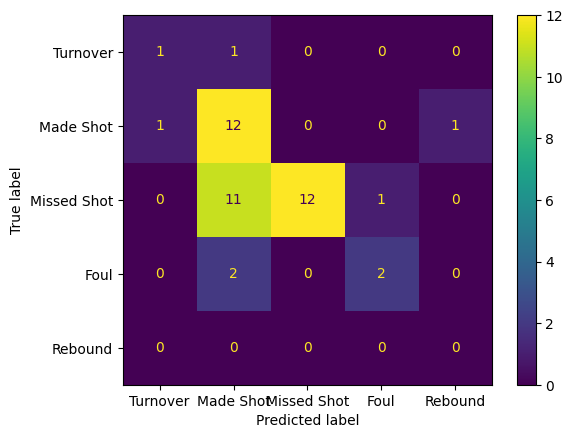

Ground Truth: 2, Predicted: 2
Ground Truth: 2, Predicted: 2
Ground Truth: 3, Predicted: 3
Ground Truth: 3, Predicted: 3
Ground Truth: 1, Predicted: 1
Ground Truth: 1, Predicted: 1
Ground Truth: 1, Predicted: 1
Ground Truth: 2, Predicted: 2
Ground Truth: 2, Predicted: 2
Ground Truth: 1, Predicted: 1
Ground Truth: 3, Predicted: 3
Ground Truth: 1, Predicted: 2
Ground Truth: 2, Predicted: 2
Ground Truth: 1, Predicted: 1
Ground Truth: 1, Predicted: 1
Ground Truth: 1, Predicted: 1
Ground Truth: 3, Predicted: 3
Ground Truth: 1, Predicted: 1
Ground Truth: 2, Predicted: 2
Ground Truth: 2, Predicted: 2
Ground Truth: 2, Predicted: 2
Ground Truth: 1, Predicted: 1
Ground Truth: 0, Predicted: 0
Ground Truth: 1, Predicted: 1
Ground Truth: 1, Predicted: 1
Ground Truth: 1, Predicted: 1
Ground Truth: 1, Predicted: 1
Ground Truth: 3, Predicted: 1
Ground Truth: 2, Predicted: 2
Ground Truth: 1, Predicted: 1
Ground Truth: 1, Predicted: 1
Ground Truth: 1, Predicted: 1
Ground Truth: 3, Predicted: 3
Ground Tru

In [ ]:
# Calculate and display the confusion matrix

cm = confusion_matrix(all_test_labels, all_test_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Turnover', 'Made Shot', 'Missed Shot','Foul','Rebound'])  # Replace with actual action names
cm_display.plot()
plt.show()

# Print comparison of ground truth vs predicted action types
for label, pred in zip(all_labels, all_preds):
    print(f'Ground Truth: {label}, Predicted: {pred}')

description = '12 uniform frame sampling + finetune last 3 layers'

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Ground Truth': all_labels,
    'Predicted': all_preds,
    'Description': description
})

# Save the DataFrame to a CSV file
results_csv_path = 'results/final_ground_truth_vs_predicted_01.csv'
results_df.to_csv(results_csv_path, index=False)

print(f'Results saved to {results_csv_path}')

In [ ]:
#@title Eval Only from using the Finetuned Model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the pretrained model
finetuned_model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k400")

# Modify the classifier layer to match the number of classes in your dataset
num_classes = len(filtered_df['label'].value_counts()) # Update this with the correct number of classes
finetuned_model.classifier = nn.Linear(in_features=768, out_features=num_classes, bias=True)

# Load the finetuned model weights

#overfit to dallas phx games, 1.0 train acc, 0.3 eval
#checkpoint_path = './weights/action_recognition/model_epoch_5_20240618_051228.pth'
#checkpoint_path = './weights/action_recognition/model_epoch_5_20240618_084645.pth'
checkpoint_path = './weights/action_recognition/final_model_epoch_5_20240620_005720.pth'
finetuned_model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Move the model to GPU if available
finetuned_model.to(device)
finetuned_model.eval()

TimesformerForVideoClassification(
  (timesformer): TimesformerModel(
    (embeddings): TimesformerEmbeddings(
      (patch_embeddings): TimesformerPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (time_drop): Dropout(p=0.0, inplace=False)
    )
    (encoder): TimesformerEncoder(
      (layer): ModuleList(
        (0-11): 12 x TimesformerLayer(
          (drop_path): Identity()
          (attention): TimeSformerAttention(
            (attention): TimesformerSelfAttention(
              (qkv): Linear(in_features=768, out_features=2304, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
            )
            (output): TimesformerSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): TimesformerIntermediate(
            (dense

In [ ]:
class EvalBasketballDataset(Dataset):
    def __init__(self, csv_file, root_dir, clip_len=12, frame_sample_rate=1, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = Path(root_dir)
        self.clip_len = clip_len
        self.frame_sample_rate = frame_sample_rate
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Read the video file path and label
        video_id = self.annotations.iloc[idx]['video_id']
        label = self.annotations.iloc[idx]['label']
        action_type = self.annotations.iloc[idx]['actionType']
        video_path = self.root_dir / f"0021800013-dal-vs-phx_{video_id}.mp4"

        # Read video
        container = av.open(str(video_path))
        indices = self.sample_frame_indices(container.streams.video[0].frames)
        video = self.read_video_pyav(container, indices)

        if self.transform:
            video = self.transform(video)

        return video, label, action_type, str(video_path)

    def sample_frame_indices(self, num_frames):
        # Ensure unique frame indices are sampled
        total_frames = num_frames
        frame_indices = np.linspace(0, total_frames - 1, self.clip_len, dtype=np.int64)
        return frame_indices

    def read_video_pyav(self, container, indices):
        frames = []
        container.seek(0)
        for i, frame in enumerate(container.decode(video=0)):
            if i in indices:
                frames.append(frame)
            if len(frames) == len(indices):
                break
        return np.stack([x.to_ndarray(format="rgb24") for x in frames])

In [ ]:
#clear cache
torch.cuda.empty_cache()

In [ ]:
#@title From Leo or other unseen source from NSVA Data .csv file
# Load the dataset
#eval_file = './data/raw/NSVA_Data/NSVA_Data/0021800013-dal-vs-phx-exploded.csv'
eval_file =  "final_filtered_dataset.csv"
eval_df = pd.read_csv(eval_file)

#check the number of unique actionType
print(eval_df['actionType'].nunique(), 'unique actions in this df')

#see what are examples of unique actionType
print(eval_df['actionType'].unique())

# Print the first few rows of the filtered dataset to verify
eval_df.head()

#check number of count for unique actionType
print(eval_df['actionType'].value_counts())

5 unique actions in this df
['Missed Shot' 'Made Shot' 'Foul' 'Turnover' 'Rebound']
actionType
Missed Shot    82
Made Shot      81
Foul           33
Turnover       17
Rebound         7
Name: count, dtype: int64


In [ ]:
#@title Filter the Eval dataset to just five actions

# Define the action types to include
selected_actions = ['Turnover', 'Made Shot', 'Missed Shot','Foul','Rebound']

# Filter the DataFrame
filtered_eval_df = eval_df[eval_df['actionType'].isin(selected_actions)]

# Verify the filtered dataset
print(filtered_eval_df['actionType'].value_counts())

# Map selected actions to numeric labels
label_to_idx = {label: idx for idx, label in enumerate(selected_actions)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

# Update the dataset with numeric labels
filtered_eval_df['label'] = filtered_eval_df['actionType'].map(label_to_idx) # i think label and actionTypecode is the same

# Save the updated dataset
filtered_eval_df.to_csv('filtered_eval_dataset.csv', index=False)

actionType
Missed Shot    82
Made Shot      81
Foul           33
Turnover       17
Rebound         7
Name: count, dtype: int64


In [ ]:
unseen_root_dir = Path('./data/raw/NSVA_Data/NSVA_Video6') #leo put into 3 instead of 2

# Path to the cleaned CSV file
eval_file = 'filtered_eval_dataset.csv'

unseen_dataset = EvalBasketballDataset(csv_file=eval_file,
                                       root_dir=unseen_root_dir,
                                       transform=transform)

# Create the dataloader for unseen videos
unseen_loader = DataLoader(unseen_dataset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
all_labels = []
all_preds = []
all_video_paths = []
all_probs = []
all_attentions = []

with torch.no_grad():
    for videos, labels, action_types, video_paths in tqdm(unseen_loader, desc="Inference on unseen videos"):
        videos, labels = videos.to(device), labels.to(device)
        outputs = finetuned_model(videos, output_attentions=True)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)
        preds = logits.argmax(dim=1)
        attentions = outputs.attentions  # This will store the attention weights

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_video_paths.extend(video_paths)
        all_probs.extend(probs.cpu().numpy())
        # Store attentions for each video
        all_attentions.append([att.cpu().numpy() for att in attentions])


# Calculate and display the accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on unseen videos: {accuracy}')

Inference on unseen videos:   0%|          | 0/55 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  return torch.tensor(value)
/usr/local/lib/python3.10/dist-packages/transformers/feature_extraction_utils.py:141: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor

eval acc 0.8954545454545455


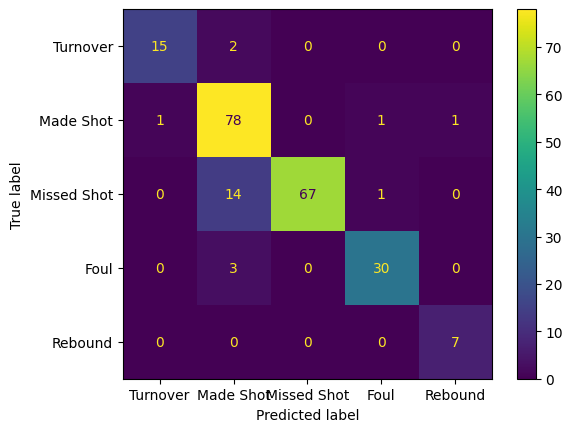

In [ ]:
# Calculate and display the accuracy
eval_accuracy = accuracy_score(all_labels, all_preds)
print('eval acc',eval_accuracy)

# Calculate and display the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_display = ConfusionMatrixDisplay(cm, display_labels=selected_actions)  # Replace with actual action names
cm_display.plot()
plt.show()

In [ ]:
# Print comparison of ground truth vs predicted action types

# label dictionary from idx to actionType
#['Turnover', 'Made Shot', 'Missed Shot','Foul','Rebound']
label_to_actionType = {0:"Turnover", 1:"Made Shot", 2:"Missed Shot",3:"Foul",4:"Rebound"}

# Print comparison of ground truth vs predicted action types
for video_path, label, pred, prob in zip(all_video_paths, all_labels, all_preds, all_probs):
    print(f'{video_path}')
    print(f'Ground Truth: {label_to_actionType[label]}')
    print(f'Predicted: {label_to_actionType[pred]} Probailities: {prob}')
    print('Correct\n' if label == pred else 'Wrong\n')

data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10978.mp4
Ground Truth: Missed Shot
Predicted: Missed Shot Probailities: [0.07204085 0.09249765 0.8133796  0.01162471 0.01045717]
Correct

data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10980.mp4
Ground Truth: Missed Shot
Predicted: Missed Shot Probailities: [0.02356886 0.14303315 0.7705813  0.05870062 0.00411609]
Correct

data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10982.mp4
Ground Truth: Made Shot
Predicted: Made Shot Probailities: [0.13422056 0.6459006  0.1844917  0.02539714 0.00999001]
Correct

data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10983.mp4
Ground Truth: Made Shot
Predicted: Made Shot Probailities: [0.02344956 0.80522716 0.00834271 0.1115432  0.05143734]
Correct

data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10985.mp4
Ground Truth: Foul
Predicted: Foul Probailities: [0.01079667 0.03823108 0.02666788 0.9128856  0.0114187 ]
Correct

data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-vs-phx_10986.mp4

In [ ]:
# List to store the rows for the DataFrame
data = []
import re
# Regular expression pattern to extract video ID
pattern = re.compile(r'_(\d+)\.mp4')

for video_path, label, pred, prob in zip(all_video_paths, all_labels, all_preds, all_probs):
    # Get the top 2 indices with the highest probabilities
    top_indices = np.argsort(prob)[-2:][::-1]  # Get top 2 indices in descending order
    top_actions = [(label_to_actionType[idx], prob[idx]) for idx in top_indices]

    # Extract top 2 action types and their probabilities
    pred_actionType1, predprob_actionType1 = top_actions[0]
    pred_actionType2, predprob_actionType2 = top_actions[1]

    # Extract video ID from URL
    match = pattern.search(video_path)
    video_id = match.group(1) if match else 'Unknown'

    # Get ground truth action type
    ground_truth_action = label_to_actionType[label]

    # Append the row to the data list
    data.append([video_path, video_id, ground_truth_action, pred_actionType1, predprob_actionType1, pred_actionType2, predprob_actionType2])

# Create a DataFrame
df_results = pd.DataFrame(data, columns=['video_path', 'video_id', 'actionType','pred_actionType1', 'predprob_actionType1', 'pred_actionType2', 'predprob_actionType2'])

In [ ]:
df_results

,video_path,video_id,actionType,pred_actionType1,predprob_actionType1,pred_actionType2,predprob_actionType2
0,data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-...,10978,Missed Shot,Missed Shot,0.813380,Made Shot,0.092498
1,data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-...,10980,Missed Shot,Missed Shot,0.770581,Made Shot,0.143033
2,data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-...,10982,Made Shot,Made Shot,0.645901,Missed Shot,0.184492
3,data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-...,10983,Made Shot,Made Shot,0.805227,Foul,0.111543
4,data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-...,10985,Foul,Foul,0.912886,Made Shot,0.038231
...,...,...,...,...,...,...,...
215,data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-...,11281,Missed Shot,Missed Shot,0.792302,Turnover,0.115365
216,data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-...,11283,Foul,Foul,0.789608,Turnover,0.097101
217,data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-...,11284,Missed Shot,Missed Shot,0.913085,Made Shot,0.048952
218,data/raw/NSVA_Data/NSVA_Video6/0021800013-dal-...,11286,Made Shot,Made Shot,0.889058,Turnover,0.061766


In [ ]:
df_results.to_csv("./data/processed/final_results.csv")